In [21]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
import csv
import json
import array as array
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)

<module 'CBfunction' from 'utils/CBfunction.py'>

In [2]:
dir = '/30_07_2019/'

In [3]:
reader = csv.reader(open('data/intercalibration19C.csv', 'r'))
dict_run_cryst = {}
dict_C3_energy_scan = {}

for row in reader:
    run,energy,crystal,_ = row
    if energy=='149.12' :
        if crystal in dict_run_cryst.keys() :
            dict_run_cryst[crystal].append(run)
        else : 
            dict_run_cryst[crystal] = []
            dict_run_cryst[crystal].append(run)       
        
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if energy=='149.12' and  (crystal=='C3' or crystal=='C2' or crystal=='C4' ) :
        if crystal in dict_run_cryst.keys() :
            dict_run_cryst[crystal].append(run)
        else : 
            dict_run_cryst[crystal] = []
            dict_run_cryst[crystal].append(run)   
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        
            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')

In [4]:
outstr = 'simoneCenter_1mm'

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_fit_B5_150): fit range of variable signal_B5_150GeV expanded to nearest bin boundaries: [3960,5940] --> [3960,5940]
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha_B5_150   5.00000e-01  2.00000e+00   -1.00000e+01  1.00000e+01
     2 exp_B5_150   7.00000e+00  3.50000e+00    0.00000e+00  1.50000e+02
     3 mean_B5_150   4.95000e+03  1.98000e+02    3.96000e+03  5.94000e+03
     4 sigma_B5_150   6.00000e+01  3.00000e+01    0.00000e+00  5.00000e+02
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRA

Warning in <TClass::Init>: no dictionary for class PositionMeasurement is available
Warning in <TClass::Init>: no dictionary for class TrackPar is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayer is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayout is available
Warning in <TClass::Init>: no dictionary for class CfgManager is available
Info in <TCanvas::Print>: pdf file plots//30_07_2019//intercalibration_fits_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: png file plots//30_07_2019//intercalibration_fits_simoneCenter_1mm.png has been created


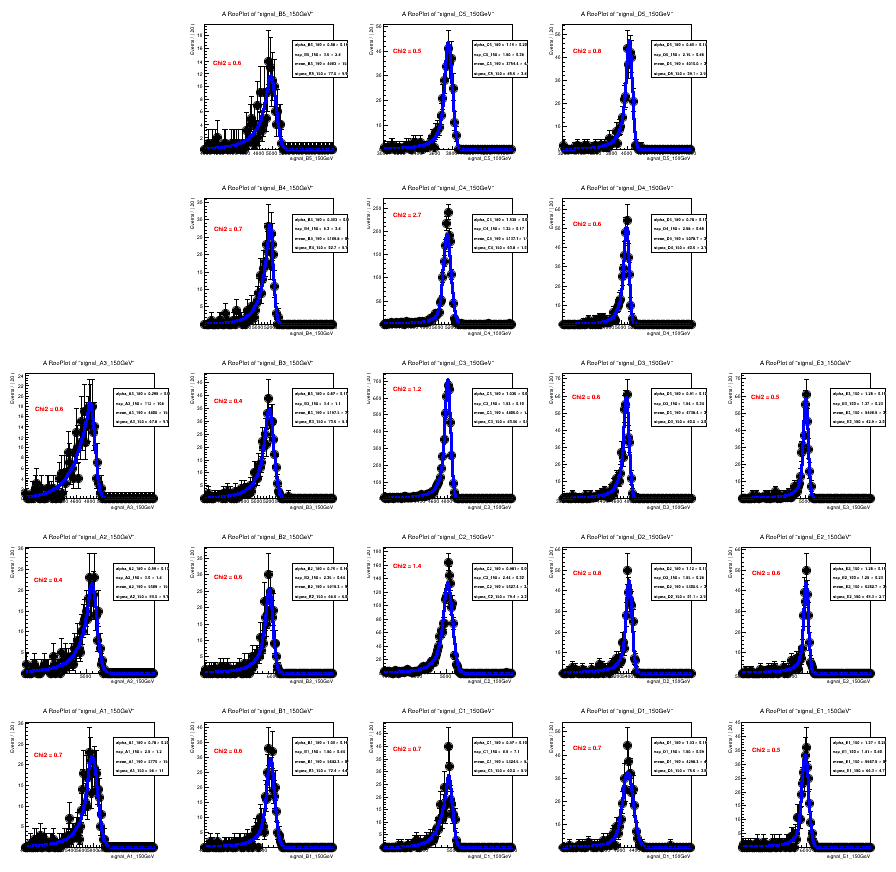

In [5]:
pos_cut = 1

c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
canvas_num=0
results = []
for crystal in naming:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1) 
        
        runs = dict_run_cryst[crystal]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
    
        myCB = CB.CBfunction(tree)
        myCB.set_crystal(crystal)
        myCB.set_energy('150')
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        myCB.prepare_histogram()
        myCB.CBintialization()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[crystal] = myCB.fitResults()
        results.append(tmp_dict)
        
        canvas_num+=1
c.Draw()
c.SaveAs('plots/%s/intercalibration_fits_%s.pdf'%(dir,outstr))
c.SaveAs('plots/%s/intercalibration_fits_%s.png'%(dir,outstr))
with open('output/%s/intercalibration_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(results,fp)
    
dict_crystals_calibration = {}
meanC3 = 1.
for item in results:
    if item.keys()[0] == 'C3' :
        meanC3 = item['C3']['CBmean'][0]
for item in results:
    dict_crystals_calibration[item.keys()[0]] = meanC3/item[item.keys()[0]]['CBmean'][0]

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_fit_C3_49.99): fit range of variable signal_C3_50GeV expanded to nearest bin boundaries: [1272,1908] --> [1260,1920]
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **  190 **SET PRINT           1
 **********
 **********
 **  191 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha_C3_49.99   5.00000e-01  2.00000e+00   -1.00000e+01  1.00000e+01
     2 exp_C3_49.99   7.00000e+00  3.50000e+00    0.00000e+00  1.50000e+02
     3 mean_C3_49.99   1.59000e+03  6.36000e+01    1.27200e+03  1.90800e+03
     4 sigma_C3_49.99   6.00000e+01  3.00000e+01    0.00000e+00  5.00000e+02
 **********
 **  192 **SET ERR         0.5
 **********
 **********
 **  193 **SET PRINT           1
 **********
 **********
 **  194 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **  19

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//30_07_2019//C3_fits_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: pdf file plots//30_07_2019//C3_fits_simoneCenter_1mm.pdf has been created


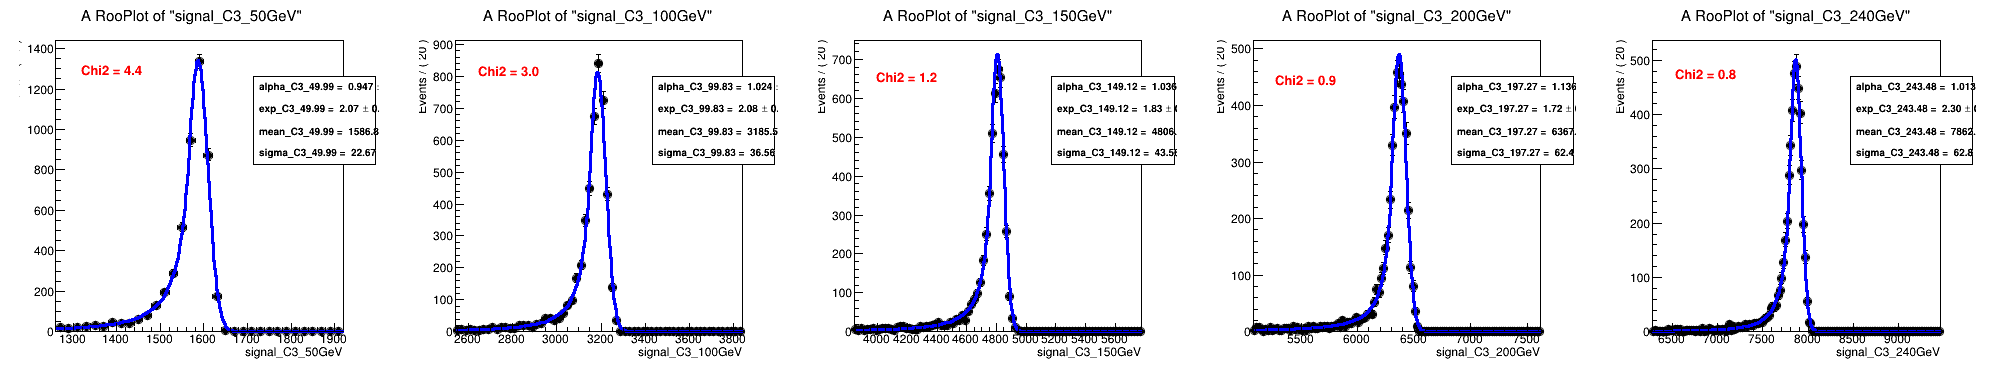

In [6]:
pos_cut = 1

c = ROOT.TCanvas("c","c",2000,400)
c.Divide(5,1)
canvas_num=0
C3_results = []
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
for energy in energies :
        c.cd(canvas_num+1) 
        
        runs = dict_C3_energy_scan[energy]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
        
        myCB = CB.CBfunction(tree)
        myCB.set_crystal(crystal)
        myCB.set_energy(energy)
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        myCB.prepare_histogram()
        myCB.CBintialization()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[energy] = myCB.fitResults()
        C3_results.append(tmp_dict)
        
        canvas_num+=1
        
c.Draw()
c.SaveAs('plots/%s/C3_fits_%s.pdf'%(dir,outstr))
c.SaveAs('plots/%s/C3_fits_%s.pdf'%(dir,outstr))

with open('output/%s/energyscans_C3_results_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(C3_results,fp)

ADC to GeV convesion factor = 0.024


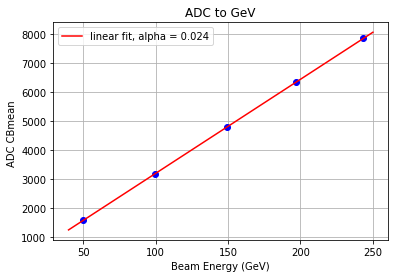

In [7]:
energies_float = []
means_C3 = []
means_unc_C3  = []
for item in C3_results:
    energies_float.append((float)(item.keys()[0]))
    means_C3.append(item[item.keys()[0]]['CBmean'][0])
    means_unc_C3.append(item[item.keys()[0]]['CBmean'][1])
    
def linear_func(x, a, b):
    return a * x + b

fig, ax = plt.subplots()
ax.plot(energies_float, means_C3,'bo' )
popt, pcov = curve_fit(linear_func, energies_float, means_C3)

shower_energy = 0.79
conversion_factor = shower_energy/popt[0]
print 'ADC to GeV convesion factor = %.3f'%conversion_factor

xfine = np.linspace(40., 250., 1000)  # define values to plot the function for
ax.plot(xfine, linear_func(xfine, popt[0], popt[1]), 'r-',label='linear fit, alpha = %.3f'%conversion_factor)
ax.set(xlabel='Beam Energy (GeV)', ylabel='ADC CBmean ',
       title='ADC to GeV')

plt.legend()
plt.grid()
plt.show()
fig.savefig('plots/%s/ADC_to_GeV_%s.png'%(dir,outstr))
fig.savefig('plots/%s/ADC_to_GeV_%s.pdf'%(dir,outstr))


dict_crystals_calibration['conversion_factor'] = conversion_factor
with open('output/%s/conversion_factor_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(dict_crystals_calibration, fp)

# Sum of energies in matrix 3x3

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_fit_C3_49.99): fit range of variable signal_C3_50GeV expanded to nearest bin boundaries: [1533.6,2300.4] --> [1530,2304]
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **  598 **SET PRINT           1
 **********
 **********
 **  599 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha_C3_49.99   1.00000e+00  4.00000e+00   -2.00000e+01  2.00000e+01
     2 exp_C3_49.99   1.00000e+00  5.00000e-01    0.00000e+00  1.50000e+02
     3 mean_C3_49.99   1.91700e+03  7.66800e+01    1.53360e+03  2.30040e+03
     4 sigma_C3_49.99   6.00000e+01  3.00000e+01    0.00000e+00  5.00000e+02
 **********
 **  600 **SET ERR         0.5
 **********
 **********
 **  601 **SET PRINT           1
 **********
 **********
 **  602 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//30_07_2019//Sum3_fits_simoneCenter_1mm.pdf has been created
Info in <TCanvas::Print>: pdf file plots//30_07_2019//Sum3_fits_simoneCenter_1mm.pdf has been created


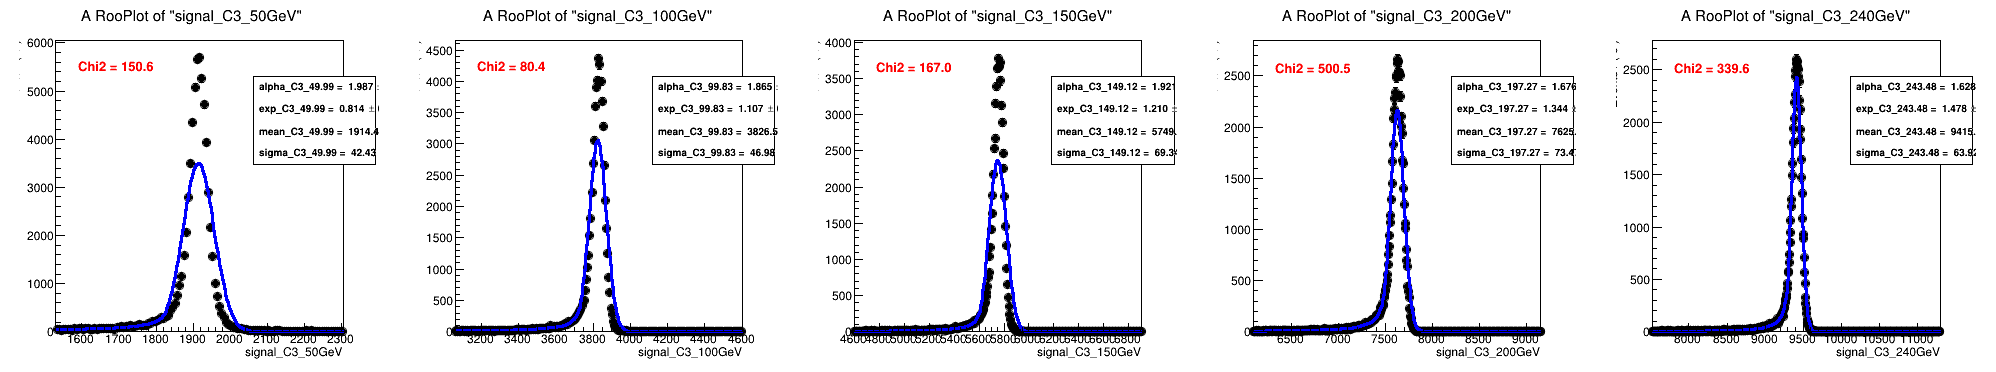

In [26]:
pos_cut = 4
c = ROOT.TCanvas("c","c",2000,400)
c.Divide(5,1)
canvas_num=0
Sum3_results = []
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
crystal='C3'
for energy in energies :      
        c.cd(canvas_num+1) 
        
        runs = dict_C3_energy_scan[energy]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/ECAL_H4_October2018_%s.root"%run)
        
        myCB = CB.CBfunction(tree)
        myCB.nbins = 2000
       # myCB.xmin = 0
       # myCB.xmax = 300
        myCB.a_initial = 1
        myCB.n_initial = 1
        myCB.set_crystal(crystal)
        myCB.set_energy(energy)
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        myCB.prepare_sumhistogram(dict_crystals_calibration,matrix_3)
        
        myCB.CBintialization()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[energy] = myCB.fitResults()
        Sum3_results.append(tmp_dict)
        
        canvas_num+=1
        
c.Draw()
c.SaveAs('plots/%s/Sum3_fits_%s.pdf'%(dir,outstr))
c.SaveAs('plots/%s/Sum3_fits_%s.pdf'%(dir,outstr))

with open('output/%s/Sum3_results_%s.json'%(dir,outstr), 'w') as fp:
    json.dump(Sum3_results,fp)    
    

ADC to GeV convesion factor = 0.026


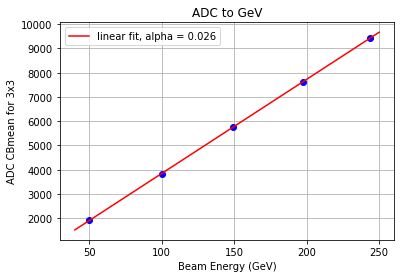

In [39]:
energies_float = []
means_sum3 = []
means_unc_sum3  = []
sigmas_sum3 = []
sigmas_unc_sum3  = []
sigma_over_mean_sum3 = []
for num,item in enumerate(Sum3_results):
    energies_float.append((float)(item.keys()[0]))
    means_sum3.append(item[item.keys()[0]]['CBmean'][0])
    means_unc_sum3.append(item[item.keys()[0]]['CBmean'][1])
    sigmas_sum3.append(item[item.keys()[0]]['CBsigma'][0])
    sigmas_unc_sum3.append(item[item.keys()[0]]['CBsigma'][1])
    sigma_over_mean_sum3.append(sigmas_sum3[num]/means_sum3[num])

    
    
def linear_func(x, a, b):
    return a * x + b

fig, ax = plt.subplots()
ax.plot(energies_float, means_sum3,'bo' )
popt, pcov = curve_fit(linear_func, energies_float, means_sum3)

shower_energy_sum3 = 1.0
conversion_factor_sum3 = shower_energy_sum3/popt[0]
print 'ADC to GeV convesion factor = %.3f'%conversion_factor_sum3

xfine = np.linspace(40., 250., 1000)  # define values to plot the function for
ax.plot(xfine, linear_func(xfine, popt[0], popt[1]), 'r-',label='linear fit, alpha = %.3f'%conversion_factor_sum3)
ax.set(xlabel='Beam Energy (GeV)', ylabel='ADC CBmean for 3x3',
       title='ADC to GeV')

plt.legend()
plt.grid()
plt.show()
fig.savefig('plots/%s/ADC_to_GeV_sum3_%s.png'%(dir,outstr))
fig.savefig('plots/%s/ADC_to_GeV_sum3_%s.pdf'%(dir,outstr))


#dict_crystals_calibration['conversion_factor_sum3'] = conversion_factor
#with open('output/%s/conversion_factor_%s.json'%(dir,outstr), 'w') as fp:
 #   json.dump(dict_crystals_calibration, fp)

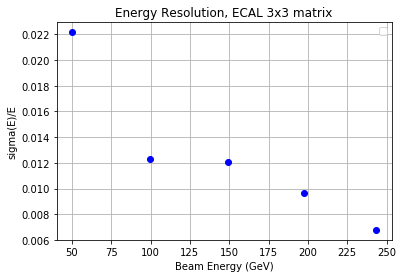

In [44]:
fig, ax = plt.subplots()
ax.plot(energies_float, sigma_over_mean_sum3,'bo' )
ax.set(xlabel='Beam Energy (GeV)', ylabel="sigma(E)/E",
       title='Energy Resolution, ECAL 3x3 matrix')

plt.legend()
plt.grid()
plt.show()
fig.savefig('plots/%s/energy_res_sum3_%s.png'%(dir,outstr))
fig.savefig('plots/%s/energy_res_sum3_%s.pdf'%(dir,outstr))
